In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import pylab
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import os;
path="/home/michaeljgrogan/Desktop/electricity-consumption-neural-master"
os.chdir(path)
os.getcwd()

Using TensorFlow backend.


'/home/michaeljgrogan/Desktop/electricity-consumption-neural-master'

In [2]:
# Form dataset matrix
def create_dataset(dataset, previous=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-previous-1):
		a = dataset[i:(i+previous), 0]
		dataX.append(a)
		dataY.append(dataset[i + previous, 0])
	return np.array(dataX), np.array(dataY)

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = read_csv('dccelectricitycivicsblocks34p20130221-1840.csv', engine='python', skipfooter=3)
df2=df.rename(columns=df.iloc[0])
df3=df2.drop(df.index[0])
df3
df3.drop(df3.index[0])
df4=df3.drop('Date', axis=1)
df5=df4.drop('Values', axis=1)
df5
df6=df5.dropna()
df7=df6.values
df7
dataset=np.sum(df7, axis=1, dtype=float)
dataset

array([4981.5001927 , 5166.60016445, 3046.35014537, 3101.10013769,
       4908.60016439, 4858.50017742, 4905.00019836, 4999.95019526,
       3075.90013122, 3023.5501442 , 5004.6001587 , 5199.30019957,
       5226.75017163, 5162.55022428, 4991.55017468, 2950.20010378,
       4883.85017776, 5055.15017129, 5084.10021592, 4914.00019451,
       3581.55014991, 2981.55008892, 2967.00011064, 3515.70014566,
       4721.10016438, 4931.85019494, 5020.05018234, 4799.40017322,
       3043.20012856, 2929.05012318, 3423.45014192, 4949.55017475,
       5155.05015188, 5238.75021174, 5129.10016059, 3088.95013995,
       3017.40010454, 5041.95018196, 5170.80017096, 5250.90023994,
       5239.35021975, 5163.60019308, 3169.65013694, 3034.65012932,
       5056.05021094, 5052.6001988 , 5048.2501869 , 4971.75019264,
       3013.20013239, 2919.45011703, 4830.0002022 , 5007.90018087,
       5028.00018885, 5088.60017207, 5092.35015869, 3069.90011787,
       2909.85011099, 4923.60022544, 5136.75021744, 5233.65021

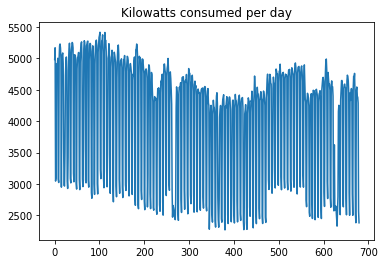

In [4]:
plt.plot(dataset)
plt.title("Kilowatts consumed per day")
plt.show()

std1=np.std(dataset)
mean1=np.mean(dataset)
cv1=std1/mean1 #Coefficient of Variation

from numpy import log
dataset = log(dataset)

std2=np.std(dataset)
mean2=np.mean(dataset)
cv2=std2/mean2 #Coefficient of Variation

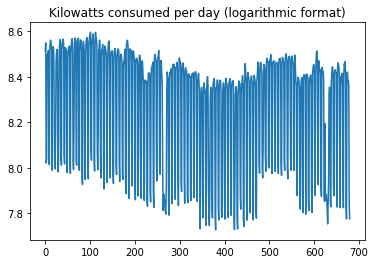

In [5]:
plt.plot(dataset)
plt.title("Kilowatts consumed per day (logarithmic format)")
plt.show()

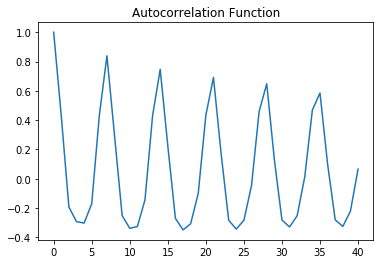

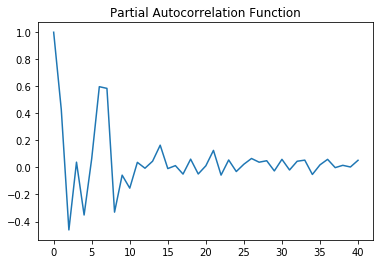

In [7]:
acf=statsmodels.tsa.stattools.acf(dataset)
plt.plot(acf)
plt.title("Autocorrelation Function")
plt.show()
pacf=statsmodels.tsa.stattools.pacf(dataset)
plt.title("Partial Autocorrelation Function")
plt.plot(pacf)

In [9]:
# Dickey-Fuller Test
result = adfuller(dataset)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.251146
p-value: 0.017209
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [ ]:
meankwh=np.mean(dataset)

dataset=dataset.reshape(-1,1)

# normalize dataset with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

In [ ]:
# Training and Test data partition
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t-1 and Y=t (MODIFY TIME HERE)
previous = 50
X_train, Y_train = create_dataset(train, previous)
X_test, Y_test = create_dataset(test, previous)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Generate LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

In [ ]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Train predictions
trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

# Test predictions
testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(previous*2)+1:len(dataset)-1, :] = testpred

# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.title("Predicted vs. Actual Consumption")
plt.show()

In [ ]:
Y_test=np.exp(Y_test)
predictions=predictions.reshape(1,-1)
predictions=np.exp(predictions)

percentage_error=((predictions-Y_test)/Y_test)
percentage_error=abs(percentage_error)
mean=np.mean(percentage_error)
mean
percentage_error=pd.DataFrame(percentage_error)
below10=percentage_error[percentage_error < 0.10].count()
all=percentage_error.count()
np.sum(below10)
np.sum(all)